In [9]:
import torch 
from torch.utils.data import DataLoader 
from tqdm import tqdm 
import numpy as np
from typing import List, Optional, Tuple
import sys 
sys.path.insert(0, "../../")
from DEFAULTS import BASE_PATH 
from loaders import get_dataset 
from model_builder import get_pretrained_model_v2 

DATASET = "peroxisome"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_IMAGENET1K_V1"
GLOBAL_POOL = "avg"


def get_classes(dataset: str):
    if dataset == "optim":
        return ["Actin", "Tubulin", "CaMKII", "PSD95"]  
    elif dataset == "neural-activity-states":
        return ["Block", "0Mg", "GluGly", "48hTTX"]
    elif dataset == "peroxisome":
        return ["4hMeOH", "6hMeOH", "8hMeOH", "16hMeOH"]
    elif dataset == "polymer-rings":
        return ["CdvB1", "CdvB2"]
    elif dataset == "dl-sim":
        return ["adhesion", "factin", "microtubule", "mitosis"]
    else:
        raise ValueError(f"Dataset {dataset} not supported")
    
CLASSES = get_classes(DATASET)
N_CLASSES = len(CLASSES)


In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on {DEVICE} ---")

model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0,
    pretrained=True if "imagenet" in WEIGHTS.lower() else False,
    in_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.to(DEVICE)
model.eval()

--- Running on cuda ---
mask_ratio 0.0
pretrained True
in_channels 3
blocks all
num_classes 4
--- mae-lightning-small | Pretrained Image-Net or from scratch ---

--- Loaded model mae-lightning-small with ImageNet weights ---
--- ViT case with none-ImageNet weights or from scratch ---
--- ViT case with ImageNet weights ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


In [11]:
_, _, test_loader = get_dataset(
    name=DATASET,
    transform=None,
    training=True,
    path=None,
    batch_size=cfg.batch_size,
    n_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
)

=== Balancing dataset ===
----------
Class 4hMeOH samples: 88
Class 6hMeOH samples: 88
Class 8hMeOH samples: 88
Class 16hMeOH samples: 88
----------
=== Balancing dataset ===
----------
Class 4hMeOH samples: 23
Class 6hMeOH samples: 23
Class 8hMeOH samples: 23
Class 16hMeOH samples: 23
----------
=== Balancing dataset ===
----------
Class 4hMeOH samples: 61
Class 6hMeOH samples: 61
Class 8hMeOH samples: 61
Class 16hMeOH samples: 61
----------
Training size: 352
Validation size: 92
Test size: 244


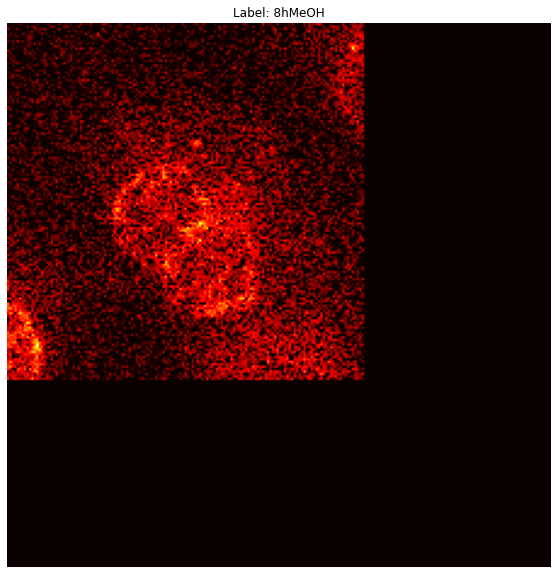

In [27]:
import matplotlib.pyplot as plt
N = len(test_loader.dataset)

i = np.random.randint(0, N)
img = test_loader.dataset[i][0].squeeze().cpu().numpy()
img = img[0] if "imagenet" in WEIGHTS.lower() else img
m, M = np.min(img), np.max(img)
img = (img - m) / (M - m)
label = test_loader.dataset[i][1]["label"]
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="hot")
plt.title(f"Label: {CLASSES[label]}")
plt.axis("off")
plt.show()



In [118]:
embeddings, labels, dataset_idx = [], [], []
N = len(test_loader.dataset)
with torch.no_grad():
    for i in range(N):
        img = test_loader.dataset[i][0].unsqueeze(0)
        metadata = test_loader.dataset[i][1]
        img = img.to(DEVICE)
        label = metadata["label"]
        d_id = metadata["dataset-idx"]
        output = model.forward_features(img)
        embeddings.append(output)
        labels.append(label)
        dataset_idx.append(d_id)

embeddings = torch.cat(embeddings, dim=0)
labels = np.array(labels)
dataset_idx = np.array(dataset_idx)
print(embeddings.shape, labels.shape)
assert embeddings.shape[0] == labels.shape[0]

torch.Size([1242, 384]) (1242,)


In [119]:
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange


num_repetitions = 50
num_samples = 30
rep_accuracies = []
for n in trange(embeddings.shape[0]):
    random_embedding = embeddings[n]
    target_label = labels[n]
    img = test_loader.dataset[n][0].squeeze().cpu().numpy()
    img = img[0] if "imagenet" in WEIGHTS.lower() else img
    similarities = F.cosine_similarity(embeddings, random_embedding.unsqueeze(0), dim=1).cpu().numpy()
    sorted_indices = np.argsort(similarities)[::-1]
    query_labels = []

    for i in sorted_indices[1:num_samples+1]:
        sim = similarities[i]
        data_index = dataset_idx[i]
        similar_img = test_loader.dataset[data_index][0].squeeze().cpu().numpy()
        query_labels.append(labels[i])
        similar_img = similar_img[0] if "imagenet" in WEIGHTS.lower() else similar_img
        # if labels[i] != target_label:
        #     fig, axs = plt.subplots(1, 2)
        #     axs[0].imshow(img, cmap='hot')
        #     axs[1].imshow(similar_img, cmap='hot')
        #     axs[1].set_title(f"Similarity: {sim:.2f}")
        #     for ax in axs:
        #         ax.axis('off')
        #     plt.show()

    retrieval_accuracy = np.sum(np.array(query_labels) == target_label) / len(query_labels)
    rep_accuracies.append(retrieval_accuracy)

print(f"Average retrieval accuracy: {np.mean(rep_accuracies):.2f} ± {np.std(rep_accuracies):.2f}")



100%|██████████| 1242/1242 [00:30<00:00, 40.60it/s]

Average retrieval accuracy: 0.88 ± 0.22
